# XPCS Pipeline for SAXS
"This notebook corresponds to version {{ version }} of the pipeline tool: https://github.com/NSLS-II/pipelines"

This notebook begins with a raw time-series of images and ends with $g_2(t)$ for a range of $q$, fit to an exponential or stretched exponential, and a two-time correlation functoin.

## Overview

* Setup: load packages/setup path
* Load Metadata & Image Data
* Apply Mask
* Clean Data: shutter open/bad frames
* Get Q-Map
* Get 1D curve
* Define Q-ROI (qr, qz)
* Check beam damage
* One-time Correlation
* Fitting
* Two-time Correlation
The important scientific code is imported from the [chxanalys](https://github.com/yugangzhang/chxanalys/tree/master/chxanalys) and [scikit-beam](https://github.com/scikit-beam/scikit-beam) project. Refer to chxanalys and scikit-beam for additional documentation and citation information.

## CHX Olog NoteBook
CHX Olog (https://logbook.nsls2.bnl.gov/11-ID/)

## Setup

Import packages for I/O, visualization, and analysis.

In [2]:
from chxanalys.chx_libs import (np, roi, time, datetime, os,  
                                getpass, db, get_images,LogNorm, plt,tqdm, utils, Model)

from chxanalys.chx_generic_functions import (get_detector, get_fields, get_sid_filenames,  
     load_data, load_mask,get_fields, reverse_updown, ring_edges,get_avg_img,check_shutter_open,
    apply_mask, show_img,check_ROI_intensity,run_time, plot1D, get_each_frame_intensity,                                             
    create_hot_pixel_mask,show_ROI_on_image,create_time_slice,save_lists, 
                        save_arrays, psave_obj,pload_obj )
 

from chxanalys.XPCS_SAXS import (get_circular_average,save_lists,get_ring_mask, get_each_ring_mean_intensity,
                                 plot_qIq_with_ROI,save_saxs_g2,plot_saxs_g2,fit_saxs_g2,cal_g2,
                                create_hot_pixel_mask,get_circular_average,get_t_iq,save_saxs_g2,
                                plot_saxs_g2,fit_saxs_g2,fit_q2_rate,plot_saxs_two_g2,fit_q_rate,
                                circular_average)

from chxanalys.Two_Time_Correlation_Function import show_C12, get_one_time_from_two_time

from chxanalys.chx_compress_analysis import ( compress_eigerdata, read_compressed_eigerdata,
                                             Multifile,get_t_iqc,get_avg_imgc, get_each_frame_intensityc,
                get_each_ring_mean_intensityc, mean_intensityc,cal_waterfallc,plot_waterfallc)

from chxanalys.chx_correlationc import ( cal_g2c,Get_Pixel_Arrayc,auto_two_Arrayc,get_pixelist_interp_iq,)
from chxanalys.Create_Report import create_pdf_report

%matplotlib notebook

In [3]:

plt.rcParams.update({'figure.max_open_warning': 0})

In [4]:
#%reset

In [5]:
%%javascript
var nb = IPython.notebook;
var kernel = IPython.notebook.kernel;
var command = "NOTEBOOK_FULL_PATH = '" + nb.base_url + nb.notebook_path + "'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [6]:
print("NOTEBOOK_FULL_PATH:\n", NOTEBOOK_FULL_PATH)

NOTEBOOK_FULL_PATH:
 /user/yuzhang/analysis/2016_2/yuzhang/August/XPCS_SAXS_Template_August_Corrected-Rep-For-SiO2.ipynb


## Make a directory for saving results

In [7]:
CYCLE = '2016_2'
username = getpass.getuser()
#username = "kyager"
#username = "anogales"

#username = "Commissioning/Protein/"

date_path = datetime.now().strftime('%Y/%m/%d')  # e.g., '2016/03/01'
data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')

##Or define data_dir here, e.g.,#data_dir = '/XF11ID/analysis/2016_2/rheadric/test/'

os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_2/yuzhang/Results/


## Load Metadata & Image Data

Print detector, scan-id, uid, datapath of data collected.

# Change these lines

In [8]:
uid = 'b5feeb' #Measurement: Silica 10k fr x .002 exp, mbs 0.1x0.6, bds 15x15, prekin .1x.08 
               #Note: we used this data for Sameera's paper



In [9]:
data_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/%s/'%uid)

os.makedirs(data_dir, exist_ok=True)
print('Results from this analysis will be stashed in the directory %s' % data_dir)

Results from this analysis will be stashed in the directory /XF11ID/analysis/2016_2/yuzhang/Results/b5feeb/


# Don't Change these lines below here

In [10]:
detector = get_detector( db[uid ] )
print ('Detector is:  %s'%detector  )
sud = get_sid_filenames(db[uid])
print ('scan_id, full-uid, data path are:  %s--%s--%s'%(sud[0], sud[1], sud[2][0] ))

Detector is:  eiger4m_single_image
scan_id, full-uid, data path are:  1846--b5feeb96-cdb0-455f-b078-1b6052326c27--/XF11ID/data/2016/07/02/c983dd73-350b-424d-ac5e_8192


In [11]:
imgs = load_data( uid, detector  )
Nimg = len(imgs)
md = imgs.md

hdf5 path = /XF11ID/data/2016/07/02/c983dd73-350b-424d-ac5e_8192_master.h5


In [12]:
try:
    md['Measurement']= db[uid]['start']['Measurement']
    md['sample']=db[uid]['start']['sample']  
    md['sample']= 'SiO2 Colloidal'
    print( md['sample'])
    
except:
    md['Measurement']= 'Measurement'
    md['sample']='sample'

SiO2 Colloidal


In [13]:
imgs

<Frames>
Length: 10000 frames
Frame Shape: 2167 x 2070
Pixel Datatype: uint16

## Overwrite Some Metadata if Wrong Input

In [14]:
md

{'Measurement': 'Silica 10k fr x .002 exp, mbs 0.1x0.6, bds 15x15, prekin .1x.08',
 'beam_center_x': 1232.0,
 'beam_center_y': 903.0,
 'count_time': 0.00199,
 'detector_distance': 4.8400002,
 'frame_time': 0.0020000001,
 'incident_wavelength': 1.2846771,
 'pixel_mask': array([[0, 0, 0, ..., 0, 0, 4],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint32),
 'sample': 'SiO2 Colloidal',
 'x_pixel_size': 7.5000004e-05,
 'y_pixel_size': 7.5000004e-05}

In [15]:
# The physical size of the pixels
dpix = md['x_pixel_size'] * 1000.  #in mm, eiger 4m is 0.075 mm
lambda_ =md['incident_wavelength']    # wavelegth of the X-rays in Angstroms
Ldet = 4.84 * 1000      # detector to sample distance (mm)
exposuretime= md['count_time']
acquisition_period = md['frame_time']
print( 'The sample is %s'%(  md['sample']  ))
print( 'Exposuretime=%s sec, Acquisition_period=%s sec'%( exposuretime, acquisition_period  ))
timeperframe = acquisition_period#for g2
#timeperframe = exposuretime#for visiblitly
#timeperframe = 2  ## manual overwrite!!!! we apparently writing the wrong metadata....

center = [  md['beam_center_x'],2167-md['beam_center_y']  ]  
          # center of the speckle pattern
          #assuming it was correctly entered in the eiger css screen


center = [   1227,1261  ] 

center=[center[1], center[0]]
print ('Beam center=', center)



The sample is SiO2 Colloidal
Exposuretime=0.00199 sec, Acquisition_period=0.002 sec
Beam center= [1261, 1227]


In [16]:
setup_pargs=dict(uid=uid, dpix= dpix, Ldet=Ldet, lambda_= lambda_, 
        timeperframe=timeperframe, center=center, path= data_dir)

In [17]:
setup_pargs

{'Ldet': 4840.0,
 'center': [1261, 1227],
 'dpix': 0.075000003562308848,
 'lambda_': 1.2846771,
 'path': '/XF11ID/analysis/2016_2/yuzhang/Results/b5feeb/',
 'timeperframe': 0.0020000001,
 'uid': 'b5feeb'}

## Apply Mask
* load and plot mask if exist 
* otherwise create a mask using Mask pipeline
* Reverse the mask in y-direction due to the coordination difference between python and Eiger software
* Reverse images in y-direction
* Apply the mask

# Change these lines

In [18]:

mask_path = '/XF11ID/analysis/2016_2/masks/'
mask_name = 'fcdba400-4b7e_mask.npy'


<IPython.core.display.Javascript object>


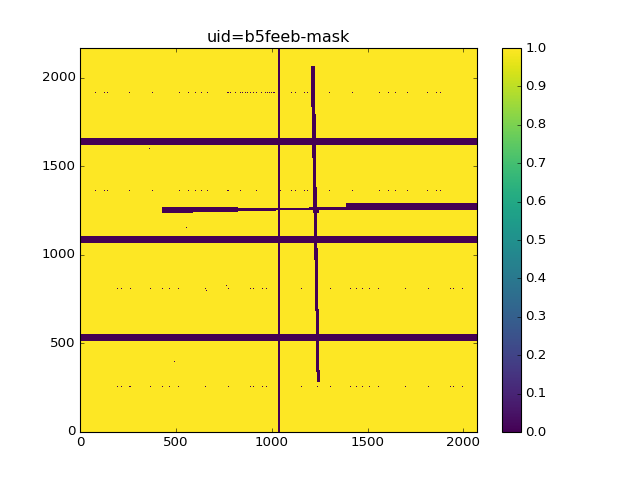

In [19]:
mask = load_mask(mask_path, mask_name, plot_ =  True, image_name = 'uid=%s-mask'%uid )

# Save metadata into the uid folder
* save mask file
* save the metadata dict

In [20]:
md['mask'] = mask
md['mask_file']= mask_path + mask_name 
md['NOTEBOOK_FULL_PATH'] = NOTEBOOK_FULL_PATH
#psave_obj(  md, data_dir + 'uid=%s-md'%uid ) #save the setup parameters
#md = pload_obj(data_dir + 'uid=%s-md'%uid  )

In [21]:
imgsa = apply_mask( imgs, mask )

In [22]:
#show_img( imgsa[0],  vmin= .01, vmax=50, logs= True, image_name= 'uid= %s'%uid) 

<IPython.core.display.Javascript object>


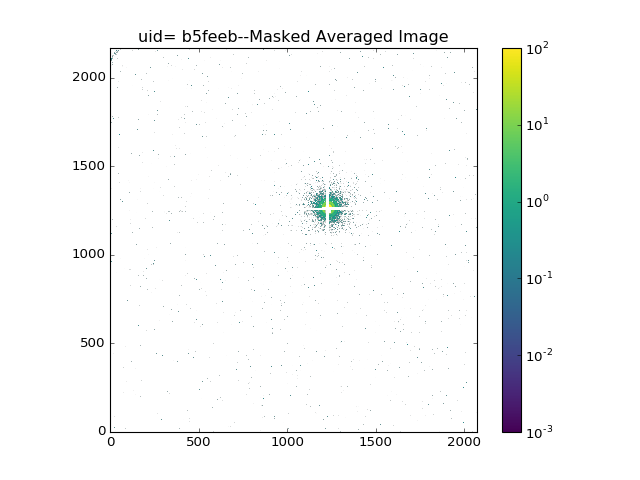

In [23]:
avg_img =  get_avg_img( imgsa, sampling = int(Nimg/3), plot_ = True, uid =uid)

## Determine Compress Or Not

In [24]:
photon_occ = len( np.where(avg_img)[0] ) / ( imgsa[0].size)
compress =  photon_occ < 1.0  #if the photon ocupation < 0.5, do compress

print ("The non-zeros photon occupation is %s."%( photon_occ))
print("Will " + ['NOT', 'DO'][compress]  + " apply compress process.")

The non-zeros photon occupation is 0.007201344720656131.
Will DO apply compress process.


## Compress Data
* Generate a compressed data with filename
* Replace old mask with a new mask with removed hot pixels
* Do average image
* Do each image sum
* Find badframe_list for where image sum above bad_pixel_threshold
* Check shutter open frame to get good time series


In [25]:
good_start = 0  #make the good_start at least 0

Averaging images:   1%|          | 112/10000 [00:00<00:08, 1118.23it/s]

Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_b5feeb96-cdb0-455f-b078-1b6052326c27.cmp.


Get each frame intensity: 100%|██████████| 10000/10000 [00:02<00:00, 3909.58it/s]

No bad frames are involved.
The good_start frame number is: 0 


<IPython.core.display.Javascript object>


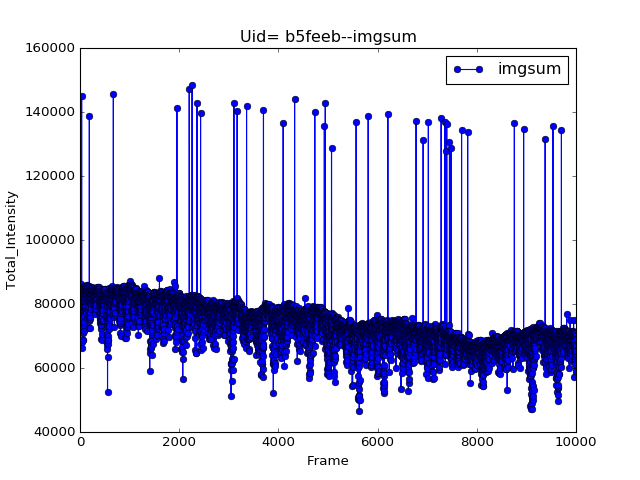

In [26]:
if True:

    if compress:
        filename = '/XF11ID/analysis/Compressed_Data' +'/uid_%s.cmp'%sud[1]
        mask, avg_img, imgsum, bad_frame_list = compress_eigerdata(imgs, mask, md, filename, 
                                    force_compress= False, bad_pixel_threshold= 1e14,nobytes=4)    

        min_inten = 10    
        good_start = max(good_start, np.where( np.array(imgsum) > min_inten )[0][0] )    
        print ('The good_start frame number is: %s '%good_start)

        FD = Multifile(filename, good_start, len(imgs))
        
        #FD = Multifile(filename, 10,100)

        plot1D( y = imgsum[ np.array( [i for i in np.arange( len(imgsum)) if i not in bad_frame_list])],
               title ='Uid= %s--imgsum'%uid, xlabel='Frame', ylabel='Total_Intensity', legend='imgsum'   )

In [27]:
#%system ls -lh {sud[2][0]+"*"}|tail -2 ; ls -lh {filename}

In [28]:
bad_pixel_threshold= 100000 #1e14  #if re-define a bad pixel threshold

In [29]:
if bad_pixel_threshold<1e14:
    mask, avg_img, imgsum, bad_frame_list = compress_eigerdata(imgs, mask, md, filename, 
                    force_compress=False, bad_pixel_threshold= bad_pixel_threshold, nobytes=4)
    min_inten = 10
    good_start = max(good_start, np.where( np.array(imgsum) > min_inten )[0][0] )   
    
    print ('The good_start frame number is: %s '%good_start)


Averaging images:   1%|          | 117/10000 [00:00<00:08, 1164.05it/s]

Using already created compressed file with filename as :/XF11ID/analysis/Compressed_Data/uid_b5feeb96-cdb0-455f-b078-1b6052326c27.cmp.


Get each frame intensity: 100%|██████████| 10000/10000 [00:02<00:00, 4031.47it/s]

Bad frame list are: [  33  188  672 1954 2202 2260 2359 2431 3103 3168 3358 3699 4096 4327 4734
 4926 4945 5071 5567 5810 6207 6776 6918 7023 7281 7360 7375 7394 7449 7480
 7693 7816 8757 8944 9378 9535 9706]
The good_start frame number is: 0 


## Define a good time series by defining a good start and good end

In [30]:
if False:
        good_start = 0  #0
        good_end =     len(imgs)
        filename = '/XF11ID/analysis/Compressed_Data' +'/uid_%s.cmp'%sud[1] 
        FD = Multifile(filename, good_start, good_end)
        avg_img= get_avg_imgc( FD,  beg= None,end=None, plot_=False )
        imgsum,bad_frame_list = get_each_frame_intensityc( FD,  bad_pixel_threshold= 1e14, plot_=False )                           


In [31]:
if not compress:   
    #sampling = 1   #sampling should be one
    sampling = 200  #sampling should be one    
    
    good_start = check_shutter_open( imgsa,  min_inten=5, time_edge = [0,10], plot_ = False )
    print ('The good_start frame number is: %s '%good_start)
    good_series = apply_mask( imgsa[good_start:], mask )
    avg_img =  get_avg_img( good_series, sampling = sampling, plot_ = False, uid =uid)
    imgsum, bad_frame_list = get_each_frame_intensity(good_series ,sampling = sampling, 
                                bad_pixel_threshold= 1e14,   plot_ = False, uid=uid)
    
    

In [32]:
print ('The bad frame list is: %s'% bad_frame_list)
print ('The number of bad frames is : %s '%len(bad_frame_list))
print ('The good_start frame number is: %s '%good_start)
md['good_start'] = good_start
md['bad_frame_list'] = bad_frame_list

The bad frame list is: [  33  188  672 1954 2202 2260 2359 2431 3103 3168 3358 3699 4096 4327 4734
 4926 4945 5071 5567 5810 6207 6776 6918 7023 7281 7360 7375 7394 7449 7480
 7693 7816 8757 8944 9378 9535 9706]
The number of bad frames is : 37 
The good_start frame number is: 0 


In [33]:
imgsum_y = imgsum[ np.array( [i for i in np.arange( len(imgsum)) if i not in bad_frame_list])]
imgsum_x = np.arange( len( imgsum_y))
save_lists(  [imgsum_x, imgsum_y], label=['Frame', 'Total_Intensity'], filename='uid=%s-imgsum'%uid, path= data_dir  )
                            

<IPython.core.display.Javascript object>


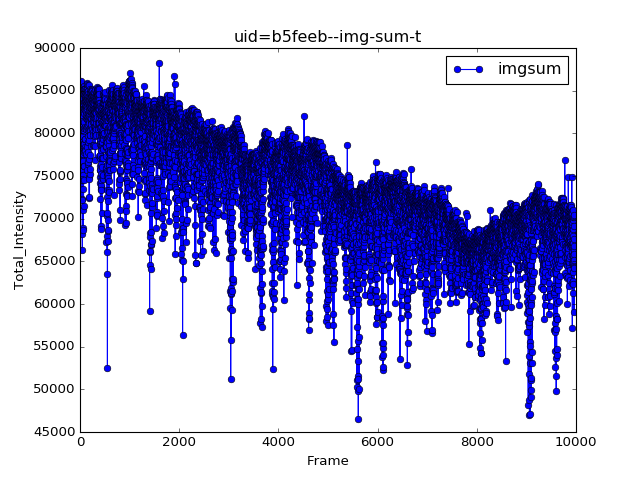

In [34]:
plot1D( y = imgsum_y, title ='uid=%s--img-sum-t'%uid, xlabel='Frame',
       ylabel='Total_Intensity', legend='imgsum', save=True, path=data_dir)

## Plot intensity average image

<IPython.core.display.Javascript object>


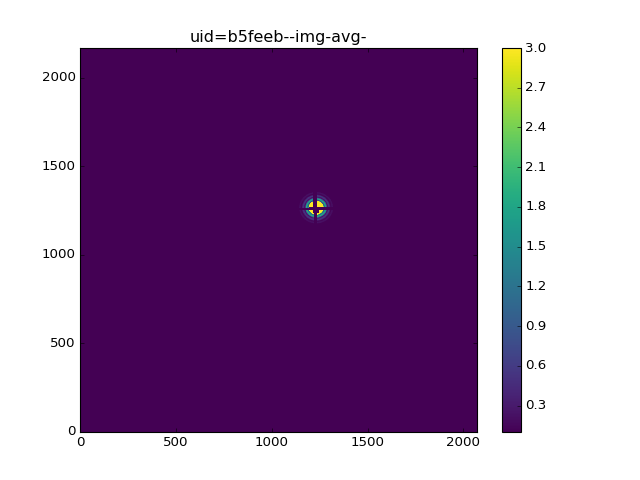

In [35]:
#avg_img = get_avg_imgc( FD,  beg=0,end=10000,sampling = 1, plot_ = False )
show_img( avg_img,  vmin=.1, vmax=3.0, logs=False, image_name= 'uid=%s--img-avg-'%uid,
        save=True, path=data_dir) 
md['avg_img'] = avg_img

In [36]:
mask[  : 1268, ] = 0

<IPython.core.display.Javascript object>


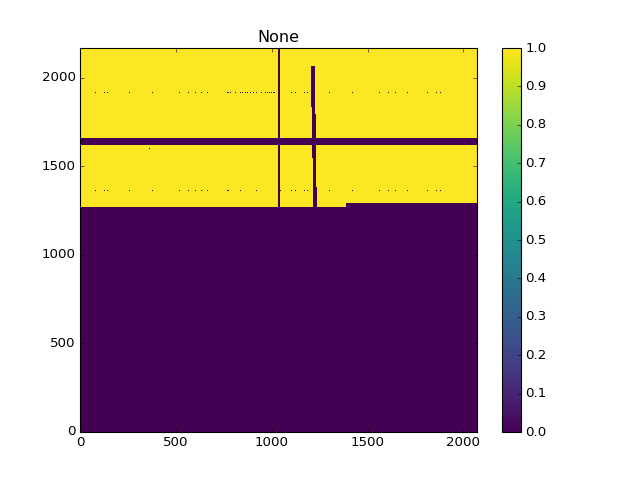

In [37]:
show_img( mask )

## Get circular average 
* Do plot and save q~iq


In [38]:
hmask = create_hot_pixel_mask( avg_img, 2**15 )
mask = mask * hmask

<IPython.core.display.Javascript object>


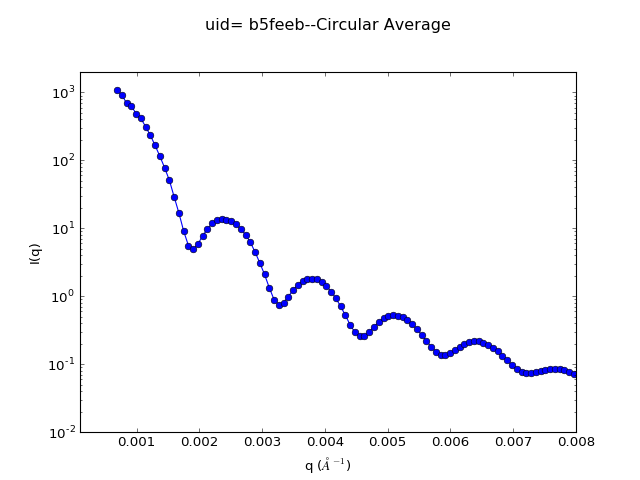

In [39]:
hmask = create_hot_pixel_mask( avg_img, 1e8)
qp, iq, q = get_circular_average( avg_img, mask * hmask, pargs=setup_pargs, nx=None,
                    plot_ = True, show_pixel=False, xlim=[0.0001,.008], ylim = [0.01, 2000])

## Define ROI
* Create ring mask defined by  inner_radius, outer_radius, width, num_rings (all in pixel unit)
* Create ring mask defined by  edges (all in pixel unit)

In [40]:
uniform = True

### Define a non-uniform distributed rings by giving edges

In [41]:
if not uniform:
    edges1 = ring_edges( inner_radius = 81-12, width=5, spacing= 0, num_rings=4 )
    edges2 = ring_edges( inner_radius = 156-12, width=5, spacing= 0, num_rings=4 )
    edges3 = ring_edges( inner_radius = 243-12, width=5, spacing= 0, num_rings=4 )
    edges = np.vstack( [ edges1,edges2,edges3  ])
    
    inner_radius= None
    outer_radius = None
    width = None
    num_rings = None

### Define a uniform distributed rings by giving inner_radius, outer_radius, width, num_rings (all in pixel unit)

In [42]:
if uniform:
    
    inner_radius= 15
    outer_radius = 105
    width = 2
    num_rings = 14
    edges = None

In [43]:
ring_mask, q_ring_center, q_ring_val = get_ring_mask(  mask, inner_radius=inner_radius, 
        outer_radius = outer_radius , width = width, num_rings = num_rings, edges=edges, pargs=setup_pargs   )
qind, pixelist = roi.extract_label_indices(  ring_mask  ) 



In [44]:
md['ring_mask'] = ring_mask
md['q_ring_center']= q_ring_center
md['q_ring_val'] = q_ring_val
md['beam_center_x'] =  center[1]
md['beam_center_y']=  center[0]


psave_obj(  md, data_dir + 'uid=%s-md'%uid ) #save the setup parameters

<IPython.core.display.Javascript object>


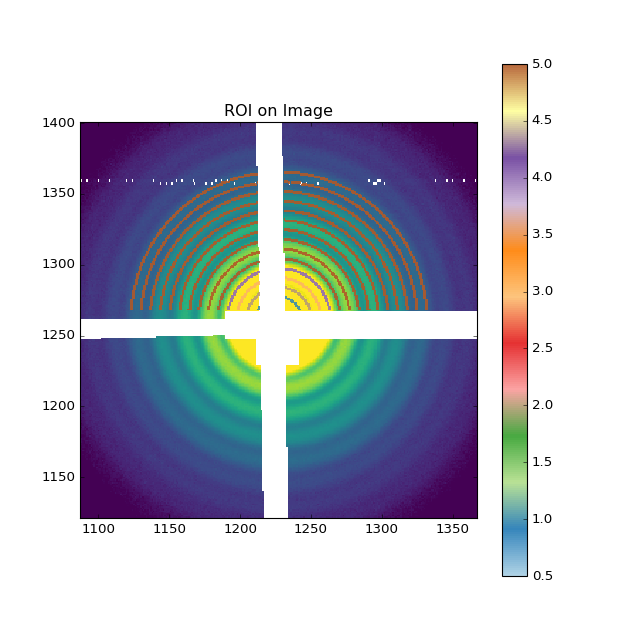

In [47]:
show_ROI_on_image( avg_img, ring_mask, center, label_on = False, rwidth=140, alpha=.9,
                 save=True, path=data_dir, uid=uid)

<IPython.core.display.Javascript object>


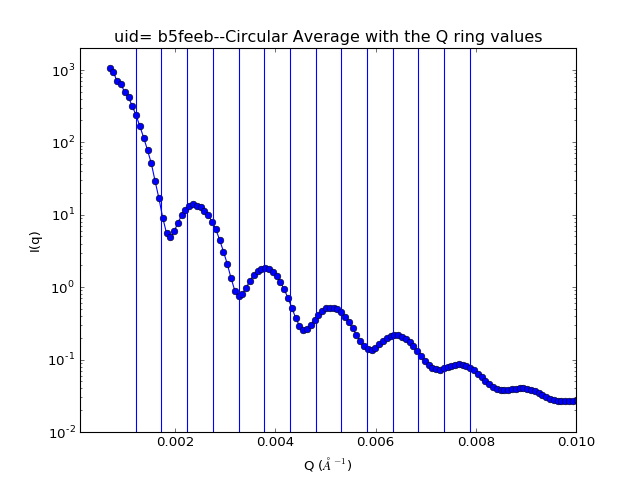

In [46]:
plot_qIq_with_ROI( q, iq, q_ring_center, logs=True, uid=uid, xlim=[0.0001,.01], ylim = [0.01, 2000],
                 save=True, path=data_dir)

## Check one ring intensity

<IPython.core.display.Javascript object>


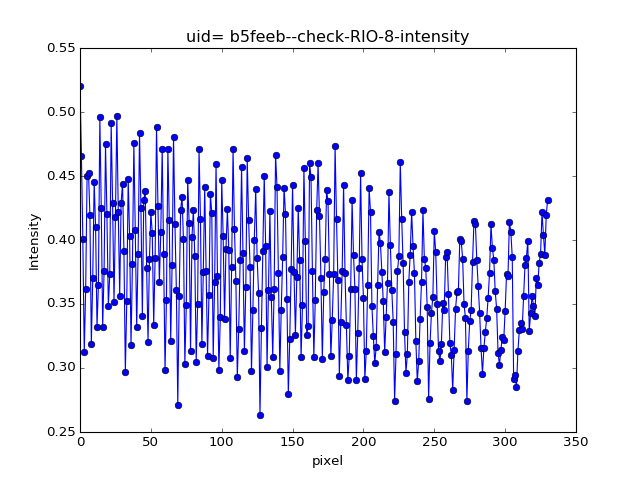

In [48]:
roi_inten = check_ROI_intensity( avg_img, ring_mask, ring_number= 8, uid =uid, save=True, path=data_dir )

## Check beam damage
* check time~I(q)
* check mean intensity of each ring as a function of time

In [49]:
#FD = Multifile(filename, good_start, len(imgs))

In [50]:
if compress:
    Nimg = FD.end - FD.beg
else:
    Nimg = len(imgsa  )

In [51]:
time_edge = create_time_slice( N= Nimg, slice_num= 3, slice_width= 10, edges = None )
time_edge =  np.array( time_edge ) + good_start

Averaging images: 100%|██████████| 10/10 [00:00<00:00, 23.70it/s]


<IPython.core.display.Javascript object>


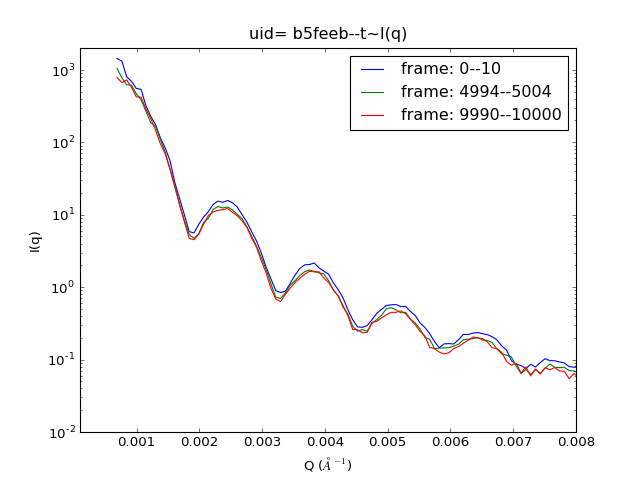

In [52]:
if compress:
    qpt, iqst, qt = get_t_iqc( FD, time_edge, mask, pargs=setup_pargs, nx=1500, 
                      plot_ = True,   xlim=[0.0001,.008], ylim = [0.01, 2000], save=True, path=data_dir )
    
else:
    qpt, iqst, qt = get_t_iq( good_series, time_edge, mask*hmask, pargs=setup_pargs, nx=1500, 
                      plot_ = True,    ylim = [0.001, 100] ,xlim=[0.0001,.15], save=True)

## Do a waterfall analysis

In [53]:
if compress:
    qindex = 8 
    wat = cal_waterfallc( FD, ring_mask, qindex= qindex, save =True, path=data_dir, uid=uid)

Get waterfall for q index=8: 100%|██████████| 10000/10000 [00:05<00:00, 1929.21it/s]


<IPython.core.display.Javascript object>


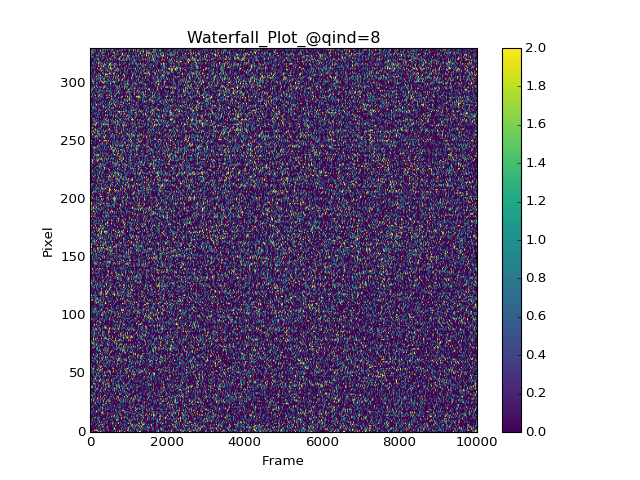

In [54]:
if compress:
    plot_waterfallc( wat, qindex, aspect=30, 
                    vmax= 2, uid=uid, save =True, 
                    path=data_dir, beg= FD.beg)

Get ROI intensity of each frame: 100%|██████████| 10000/10000 [00:05<00:00, 1738.75it/s]


<IPython.core.display.Javascript object>


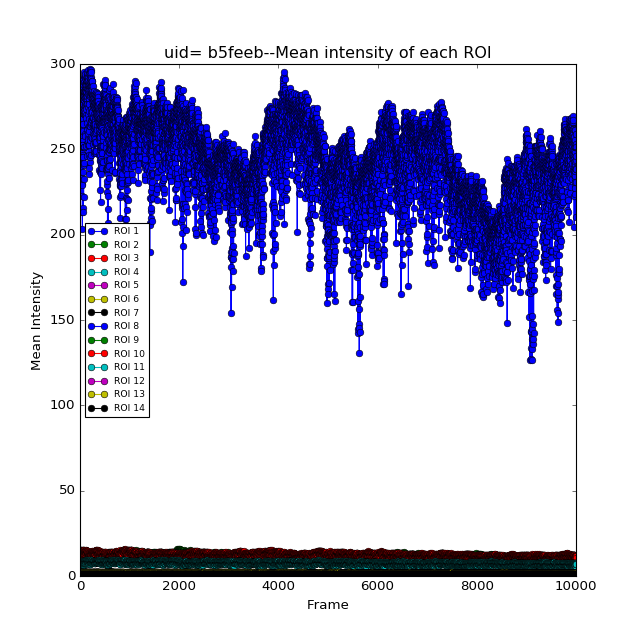

In [55]:
if compress:
    times, mean_int_sets = get_each_ring_mean_intensityc(FD, ring_mask,
                    timeperframe = None, plot_ = True, uid = uid, save=True, path=data_dir  )
    ring_avg = np.average( mean_int_sets, axis=0)
    
else:
    mean_int_sets = get_each_ring_mean_intensity(good_series, ring_mask, sampling = sampling,
                                timeperframe = md['frame_time']*sampling, plot_ = True, uid = uid, save=True  )

## One time Correlation

Note : Enter the number of buffers for Muliti tau one time correlation
number of buffers has to be even. More details in https://github.com/scikit-beam/scikit-beam/blob/master/skbeam/core/correlation.py

### if define another good_series

In [56]:
if False:
    good_start = 0
    good_end =  1000
    good_series = apply_mask( imgs[good_start:good_end-1], mask )
    

In [57]:
lag_steps = None

In [58]:
bad_frame_list

array([  33,  188,  672, 1954, 2202, 2260, 2359, 2431, 3103, 3168, 3358,
       3699, 4096, 4327, 4734, 4926, 4945, 5071, 5567, 5810, 6207, 6776,
       6918, 7023, 7281, 7360, 7375, 7394, 7449, 7480, 7693, 7816, 8757,
       8944, 9378, 9535, 9706])

In [59]:
#if compress:
#    FD = Multifile(filename, 0, len(imgs))
    #FD = Multifile(filename, 0, 40)
    #FD = Multifile(filename, 800, len(imgs))
    #FD = Multifile(filename, 0, 500 )


In [60]:
#FD = Multifile(filename, 10,100)

In [61]:
norm = get_pixelist_interp_iq( qp, iq, ring_mask, center)

In [62]:
t0 = time.time()
if compress:
    g2, lag_steps  =cal_g2c( FD,  ring_mask, bad_frame_list,good_start, num_buf = 8, 
                        imgsum= None, norm=norm )
else:
    bad_image_process = False
    if  len(bad_frame_list):
        bad_image_process = True
    print( bad_image_process  )

    g2, lag_steps  =cal_g2( good_series,  ring_mask, bad_image_process,
                       bad_frame_list,good_start, num_buf = 8 )
run_time(t0)

In this g2 calculation, the buf and lev number are: 8--12--
Bad frame involved and will be precessed!
9963 frames will be processed...


100%|██████████| 10000/10000 [00:31<00:00, 322.31it/s]

G2 calculation DONE!
Total time: 0.52 min


In [63]:
lag_steps

array([   0,    1,    2,    3,    4,    5,    6,    7,    8,   10,   12,
         14,   16,   20,   24,   28,   32,   40,   48,   56,   64,   80,
         96,  112,  128,  160,  192,  224,  256,  320,  384,  448,  512,
        640,  768,  896, 1024, 1280, 1536, 1792])

In [64]:
taus = lag_steps * timeperframe
res_pargs = dict(taus=taus, q_ring_center=q_ring_center, path=data_dir, uid=uid        )

In [65]:
taus

array([  0.00000000e+00,   2.00000009e-03,   4.00000019e-03,
         6.00000028e-03,   8.00000038e-03,   1.00000005e-02,
         1.20000006e-02,   1.40000007e-02,   1.60000008e-02,
         2.00000009e-02,   2.40000011e-02,   2.80000013e-02,
         3.20000015e-02,   4.00000019e-02,   4.80000023e-02,
         5.60000027e-02,   6.40000030e-02,   8.00000038e-02,
         9.60000046e-02,   1.12000005e-01,   1.28000006e-01,
         1.60000008e-01,   1.92000009e-01,   2.24000011e-01,
         2.56000012e-01,   3.20000015e-01,   3.84000018e-01,
         4.48000021e-01,   5.12000024e-01,   6.40000030e-01,
         7.68000036e-01,   8.96000043e-01,   1.02400005e+00,
         1.28000006e+00,   1.53600007e+00,   1.79200009e+00,
         2.04800010e+00,   2.56000012e+00,   3.07200015e+00,
         3.58400017e+00])

In [66]:
save_saxs_g2(   g2, res_pargs )

The g2 is saved in /XF11ID/analysis/2016_2/yuzhang/Results/b5feeb/ with filename as uid=b5feeb--g2.csv


### Plot the one time correlation functions

<IPython.core.display.Javascript object>


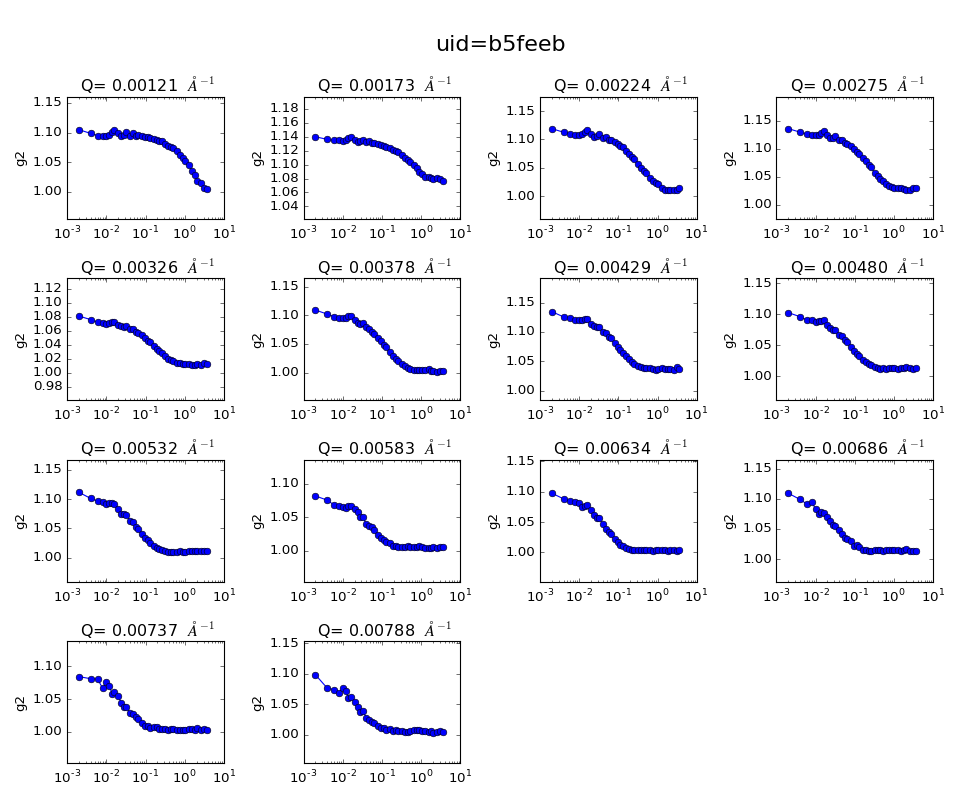

In [67]:
plot_saxs_g2( g2, taus,  vlim=[0.95, 1.05], res_pargs=res_pargs) 

# Fit g2

In [68]:
fit= True

<IPython.core.display.Javascript object>


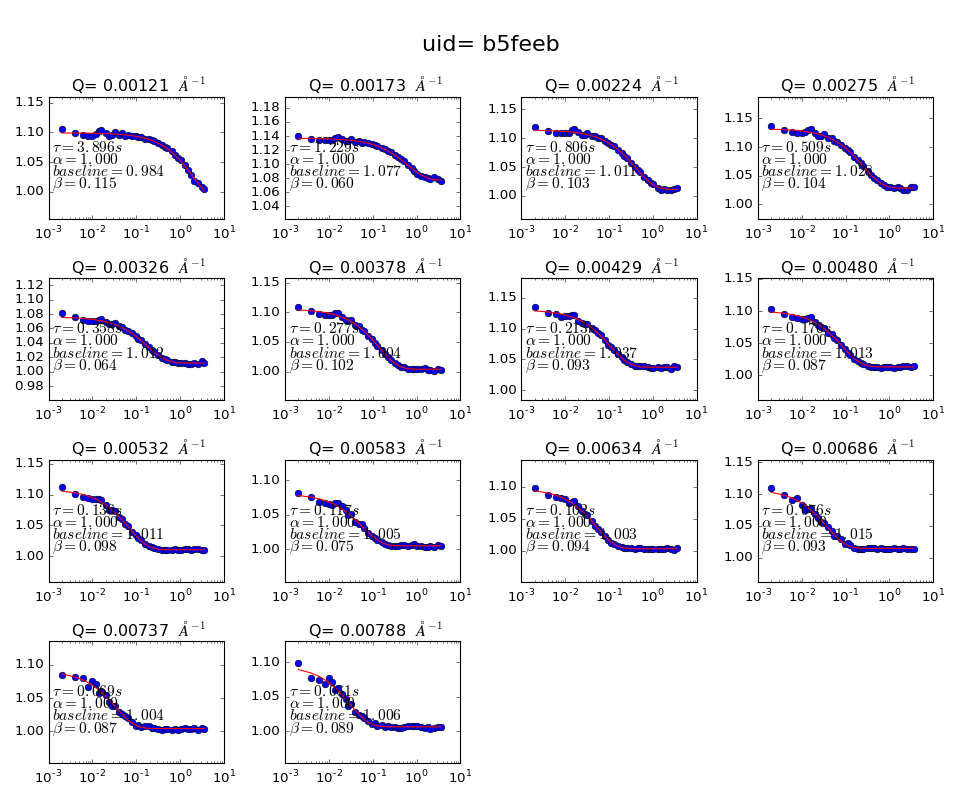

In [69]:
if fit:    
    fit_result = fit_saxs_g2( g2, res_pargs, function = 'stretched',  vlim=[0.95, 1.05], 
        fit_variables={'baseline':True, 'beta':True, 'alpha':False,'relaxation_rate':True},
        guess_values={'baseline':1.0,'beta':0.05,'alpha':1.0,'relaxation_rate':0.01})

In [70]:
psave_obj( fit_result, data_dir + 'uid=%s-g2-fit-para'%uid )

In [71]:
#fig,ax=plt.subplots()
#q_nums = [10,15,20]
#for q_num in q_nums:
#    plot1D(ax=ax, x=taus[1:], y= np.array( g2 )[1:,q_num ], logx=True)

The fitted diffusion coefficient D0 is:  2.628e+05   A^2S-1


<IPython.core.display.Javascript object>


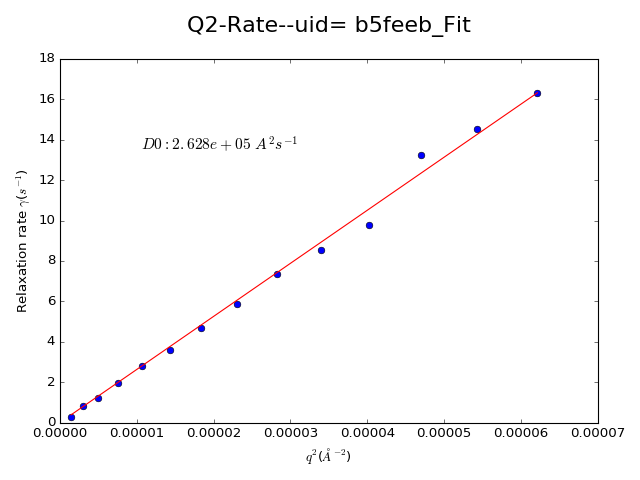

262834.08819049783

In [72]:
#fit_q_rate(  q_ring_center[6:12], result['rate'][6:12], power_variable=False,uid=uid, path= data_dir )
fit_q_rate(  q_ring_center[:], fit_result['rate'][:], power_variable= False,
           uid=uid, path= data_dir )

In [ ]:
#fig,ax=plt.subplots()
#q_nums = [10,45]
#for q_num in q_nums:
#    plot1D(ax=ax, x=data.tau[1:], y= np.array( data )[1:,q_num + 1], logx=True, legend= 'q=%.5f'%float(data.columns[q_num+1]) )

 

In [ ]:
#import matplotlib.pyplot as plt
#plt.figure()
#plt.plot(q_ring_center,result['rate'])
#plt.loglog()
#plt.show()

# For two-time

In [73]:
run_two_time = True

In [74]:
if run_two_time:
    
    if compress:
        #norm = None
        data_pixel =   Get_Pixel_Arrayc( FD, pixelist,  norm=norm ).get_data()
        g12b = auto_two_Arrayc(  data_pixel,  ring_mask, index = None   )
        
        if lag_steps is None:
            num_bufs=8
            noframes = FD.end - FD.beg
            num_levels = int(np.log( noframes/(num_bufs-1))/np.log(2) +1) +1
            tot_channels, lag_steps, dict_lag = multi_tau_lags(num_levels, num_bufs)
            max_taus= lag_steps.max()



    else:
        qind, pixelist = roi.extract_label_indices(   ring_mask  )
        #good_start = 10
        #good_end = 300 #len( imgs )
        #good_series = apply_mask( imgsr[good_start:good_end-1], maskr )
        t0 = time.time()
        data_pixel =   Get_Pixel_Array( good_series , pixelist).get_data()

        run_time(t0)
        g12b = auto_two_Array( good_series,ring_mask, data_pixel = data_pixel ) 
        
        

100%|██████████| 14/14 [01:05<00:00,  4.54s/it]


In [75]:
if run_two_time:np.save(  data_dir + 'uid=%s-Two_time'%uid, g12b)

<IPython.core.display.Javascript object>


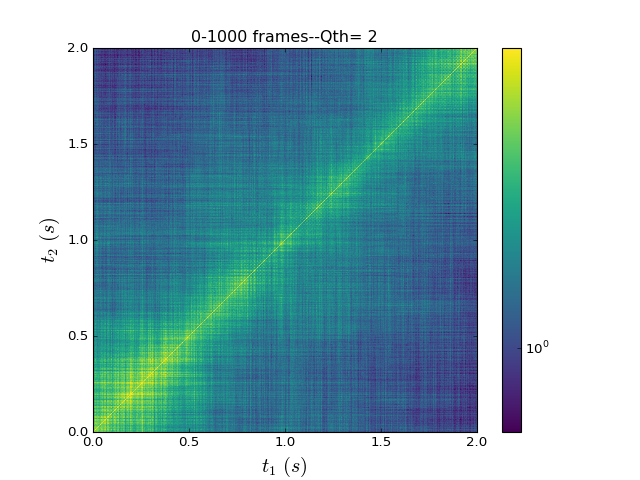

In [77]:
if run_two_time:
    show_C12(g12b, q_ind= 2, N1=0, N2=1000, vmin=.95, vmax=1.2,
             timeperframe=timeperframe,save=True, path= data_dir, uid = uid )
    

In [81]:
if run_two_time:

    if lag_steps is None:
        num_bufs=8
        noframes = FD.end - FD.beg
        num_levels = int(np.log( noframes/(num_bufs-1))/np.log(2) +1) +1
        tot_channels, lag_steps, dict_lag = multi_tau_lags(num_levels, num_bufs)
        max_taus= lag_steps.max()
        
    max_taus= lag_steps.max()    
    g2b = get_one_time_from_two_time(g12b)[:max_taus]
    
    taus2 = np.arange( g2b.shape[0])[:max_taus] *timeperframe
    res_pargs2 = dict(taus=taus2, q_ring_center=q_ring_center, path=data_dir, uid=uid        )
    save_saxs_g2(   g2b,  res_pargs2, taus=np.arange( g2b.shape[0]) *timeperframe,
                 filename='g2_from_two-time')

/opt/conda_envs/analysis/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/opt/conda_envs/analysis/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/opt/conda_envs/analysis/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/opt/conda_envs/analysis/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/opt/conda_envs/analysis/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)
/opt/conda_envs/analysis/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  war

The g2 is saved in /XF11ID/analysis/2016_2/yuzhang/Results/b5feeb/ with filename as g2_from_two-timeuid=b5feeb--g2.csv


/opt/conda_envs/analysis/lib/python3.5/site-packages/numpy/lib/nanfunctions.py:675: RuntimeWarning: Mean of empty slice
  warnings.warn("Mean of empty slice", RuntimeWarning)


<IPython.core.display.Javascript object>


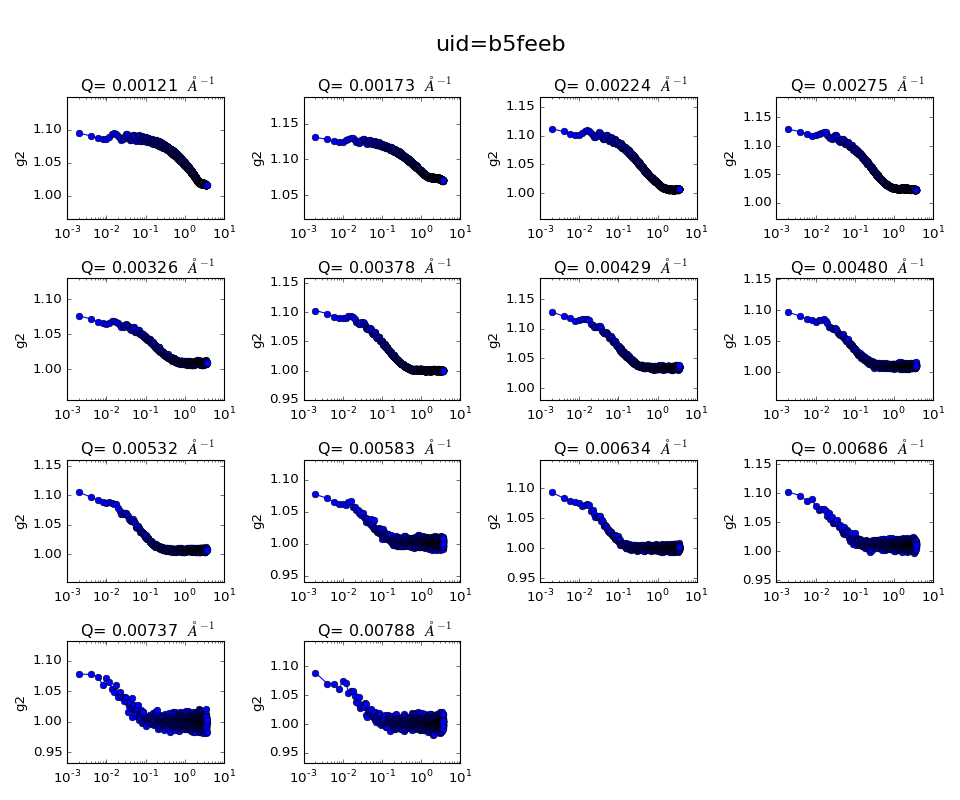

In [82]:
if run_two_time:
    plot_saxs_g2( g2b, taus2,  vlim=[0.95, 1.05], res_pargs=res_pargs2)  

<IPython.core.display.Javascript object>


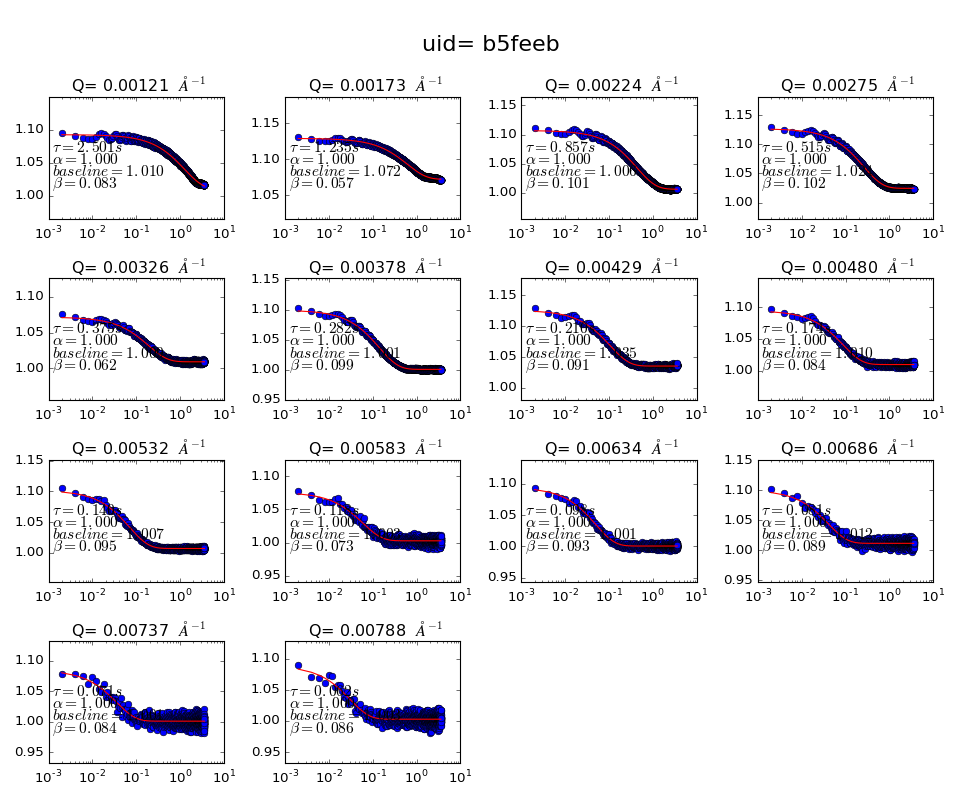

The fitted diffusion coefficient D0 is:  2.578e+05   A^2S-1


<IPython.core.display.Javascript object>


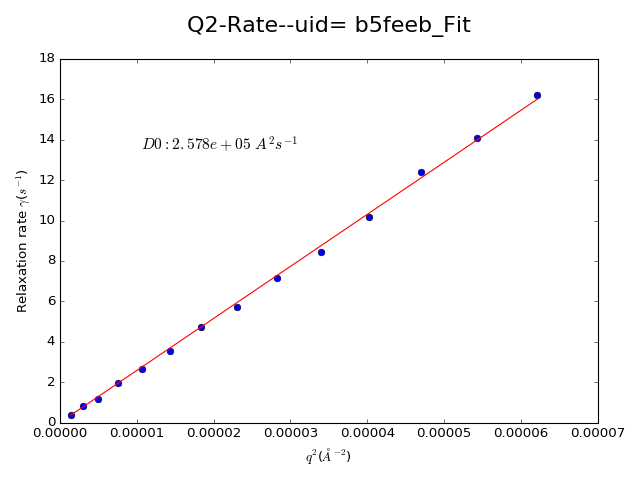

In [83]:
if run_two_time:
    result2 = fit_saxs_g2( g2b, res_pargs2, function = 'simple')#, fit_range= [0, 2000 ])
    fit_q_rate(  q_ring_center, result2['rate'], uid=uid, path= data_dir )
    save_lists( [q_ring_center**2,result2['rate']], ['q2','rate'], filename= 'Q2-rate-twoT-uid=%s'%uid, path= data_dir)

<IPython.core.display.Javascript object>


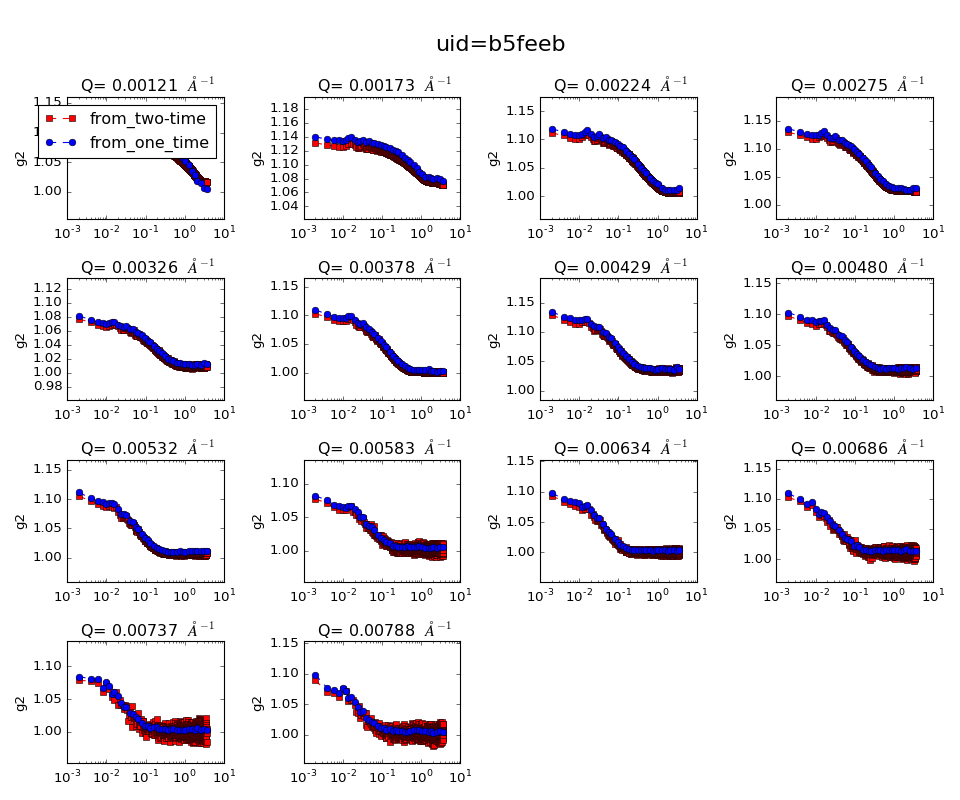

In [84]:
if run_two_time:
    plot_saxs_two_g2( g2, taus, 
                 g2b, taus2,
                 res_pargs=res_pargs, vlim=[.95, 1.05], uid= uid )

# The End!

In [85]:
create_report = True


In [86]:
username

'yuzhang'

In [87]:
pdf_out_dir = os.path.join('/XF11ID/analysis/', CYCLE, username, 'Results/')

In [88]:
%run /XF11ID/analysis/Analysis_Pipelines/Develop/chxanalys/chxanalys/Create_Report.py

In [89]:
if create_report:
    
    c= create_pdf_report(  data_dir, uid, pdf_out_dir,filename= "XPCS_Analysis_Report_for_uid=%s-2.pdf"%uid)
    
    #Page one: Meta-data/Iq-Q/ROI
    c.report_header(page=1)
    c.report_meta( top=730)
    c.report_static( top=560)
    c.report_ROI( top= 300)
    #Page Two: img~t/iq~t/waterfall/mean~t/g2/rate~q
    c.new_page()
    c.report_header(page=2)
    c.report_time_analysis( top= 720)
    c.report_one_time( top= 350)
    #Page Three: two-time/two g2
    
    if run_two_time:
        c.new_page()
        c.report_header(page=3)
        c.report_two_time(  top= 720 )
        c.save_page()
        c.done()
    else:
        c.save_page()
        c.done()        

    


****************************************
The pdf report is created with filename as: /XF11ID/analysis/2016_2/yuzhang/Results/XPCS_Analysis_Report_for_uid=b5feeb-2.pdf
****************************************


In [90]:
c.filename

'/XF11ID/analysis/2016_2/yuzhang/Results/XPCS_Analysis_Report_for_uid=b5feeb-2.pdf'

In [91]:
data_dir

'/XF11ID/analysis/2016_2/yuzhang/Results/b5feeb/'

## Attach the PDF report to Olog 

In [92]:
from chxanalys.chx_olog import LogEntry,Attachment, update_olog_uid, update_olog_id

In [93]:
os.environ['HTTPS_PROXY'] = 'https://proxy:8888'
os.environ['no_proxy'] = 'cs.nsls2.local,localhost,127.0.0.1'

In [94]:
filename = c.filename
atch=[  Attachment(open(filename, 'rb')) ] 

update_olog_uid( uid=uid, text='Add XPCS Analysis PDF Report-2', attachments= atch )

## Attach the Analysis Notebook to Olog 

In [100]:
filename = '/XF11ID/analysis/2016_2/yuzhang/August/XPCS_SAXS_Template_August_Corrected-Rep-For-SiO2.ipynb'

atch=[  Attachment(open(filename, 'rb')) ] 
update_olog_uid( uid=uid, text='Add XPCS Analysis notebook', attachments= atch )


In [101]:
NOTEBOOK_FULL_PATH

'/user/yuzhang/analysis/2016_2/yuzhang/August/XPCS_SAXS_Template_August_Corrected-Rep-For-SiO2.ipynb'

In [96]:
c.filename

'/XF11ID/analysis/2016_2/yuzhang/Results/XPCS_Analysis_Report_for_uid=b5feeb-2.pdf'

In [95]:
uid

'b5feeb'